In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

seed = 42
np.random.seed(seed)

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

# 2. EDA & 전처리

### 공통 함수 

In [3]:
def distplots(col):
    f, ax = plt.subplots(1,2, figsize=(16,5))
    sns.distplot(train[col], ax=ax[0])
    sns.distplot(test[col], ax=ax[1])

In [4]:
def boxplots(col):
    f, ax = plt.subplots(1,2, figsize=(16,5))
    sns.boxplot(train[col], ax=ax[0])
    sns.boxplot(test[col], ax=ax[1])

In [5]:
def kdeplots(col):
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.kdeplot(train[train['voted'] == 1][col], ax=ax, bw=1.5)
    sns.kdeplot(train[train['voted'] == 2][col], ax=ax, bw=1.5)
    plt.legend(['voted == 1', 'voted == 2'])
    plt.show()

In [6]:
train.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'],
      dtype='object')

In [ ]:
for f in ['Mach_score', 'Extraversion', 'Agreeableness', 'Conscientiousness',
       'EmotionalStability', 'OpennesstoExperience', 'wf', 'wr']:
    sns.lmplot(x=f, y="voted", data=train)    

In [ ]:
train['imsi'] = train.wr * train.Mach_score

for f in ['wf','wr','Mach_score','imsi']:
    kdeplots(f)

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info()

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## Target 분포

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## 컬럼 분류

In [7]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [8]:
Q_A = meta[meta.gbn=='Q_A'].index
train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


In [9]:
minus_cols = ["QeA", "QfA", "QkA", "QqA", "QrA","QaA", "QdA", "QgA", "QiA", "QnA"]
for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
    
train['Mach_score'] = train[Q_A].mean(axis = 1)
test['Mach_score'] = test[Q_A].mean(axis = 1)

In [ ]:
for f in Q_A:
    distplots(f)

In [ ]:
for f in Q_A:
    kdeplots(f)

In [ ]:
kdeplots('Mach_score')

In [ ]:
def plot_to_voted(data, var, target):
    plt.figure(figsize = (8,6))
    for tar in target:
        u = np.percentile(data[data['voted']==tar][var],95)
        d = np.percentile(data[data['voted']==tar][var],5)
        column = [val for val in data[data['voted']==tar][var] if d < val < u]
        sns.distplot(column)
    plt.title(var)
    plt.legend(target)
    plt.show()

In [ ]:
for f in Q_A:
    plot_to_voted(train, f,  train['voted'].unique())

### Q_E

In [10]:
Q_E = meta[meta.gbn == 'Q_E'].index
#train[Q_E].describe()#.to_csv('Q_E.csv')
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


In [ ]:
(4584.27+2023.76)/2

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
train[Q_E].describe()
test[Q_E].describe()

In [ ]:
for f in ['QhE','QsE']:
    distplots(f)

In [ ]:
train.loc[train.QhE > 266767, 'QhE'] = 266767

In [ ]:
train.QsE.sort_values(ascending=False)[:20]

In [ ]:
for f in ['QhE','QsE']:
    distplots(f)

In [ ]:
for f in Q_E:
    train.loc[train[f] > 20000, f] = 20000

In [ ]:
for f in Q_E:
    kdeplots(f)

In [ ]:
for f in Q_E:
    distplots(f)

In [ ]:
train.shape[0]

In [ ]:
%%time
for f in Q_E:
    maxval = test[f].max()
    for i in range(train.shape[0]):
        if train.loc[i, f] > maxval:
            train.loc[i, f] = maxval

In [6]:
train['QE'] = train[Q_E].sum(axis=1)
test['QE'] = test[Q_E].sum(axis=1)

index
0        17874
1        49565
2        29661
3        72714
4        18487
         ...  
45527    13080
45528    26033
45529    25427
45530    23673
45531    27352
Length: 45532, dtype: int64

In [ ]:
for f in Q_E:
    boxplots(f)

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
def boxplots_all(col):
    f, ax = plt.subplots(1,3, figsize=(16,5))
    sns.boxplot(train[col], ax=ax[0])
    sns.boxplot(test[col], ax=ax[1])
    sns.boxplot(df[col], ax=ax[2])

In [ ]:
for f in Q_E:
    boxplots_all(f)

In [ ]:
var = 100000
col = 'QtE'
df.loc[df[col] > var, col] = var+np.random.randint(0,1000)

f, ax = plt.subplots(1,1, figsize=(16,5))
sns.boxplot(df[col])

In [ ]:
['', 
 'QbE', 
 'QcE', 
 'QdE', 
 'QeE', 
 'QfE', 
 'QgE', 
 'QhE', 
 'QiE', 
 'QjE', 
 'QkE', 
 'QlE', 
 'QmE', 
 'QnE',
 'QoE', 
 'QpE', 
 'QqE',
 'QrE', 
 'QsE', 
 'QtE'] 

In [ ]:
for f in Q_E:
    plot_to_voted(train, f,  train['voted'].unique())

In [ ]:
for f in Q_E:
    g = sns.FacetGrid(train, col='voted').map(sns.distplot, f)

In [ ]:
for f in Q_E:
    print(f, train[f].min(), train[f].mean(), train[f].max())

<Figure size 1296x864 with 0 Axes>

Text(0.5, 1.0, 'colQ_ES')

<AxesSubplot:title={'center':'colQ_ES'}>

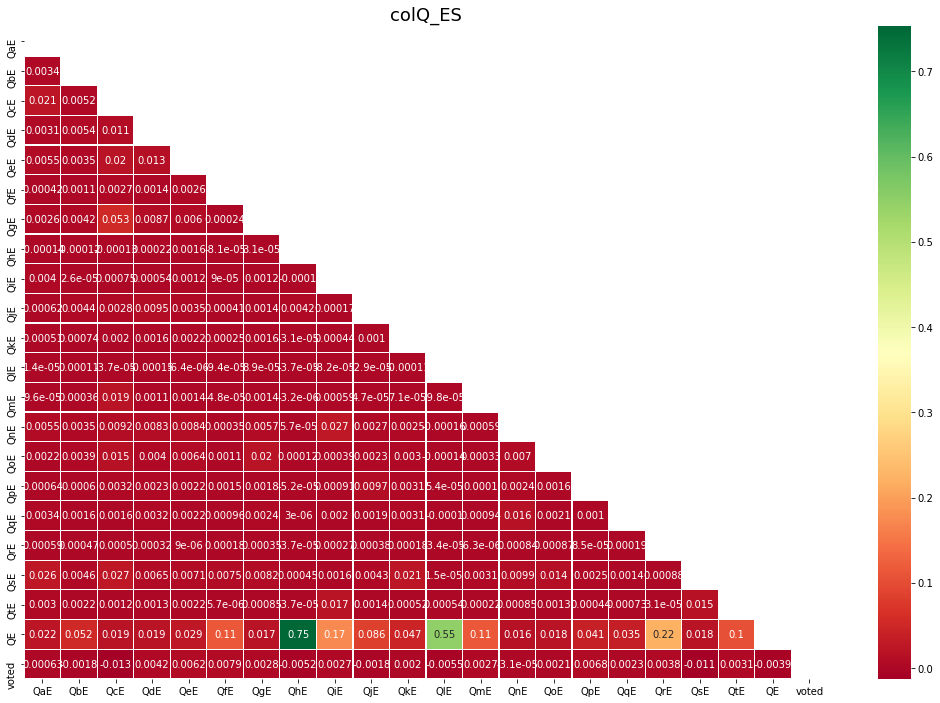

In [30]:
colQ_Es = Q_E.tolist()
colQ_Es.extend(['QE','voted'])

corr_Q_E = train[colQ_Es].corr()

mask = np.zeros_like(corr_Q_E, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('colQ_ES', fontsize=18)

sns.heatmap(corr_Q_E, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [32]:
corr_Q_E['QE'].sort_values(ascending=False)

QE       1.000000
QhE      0.752557
QlE      0.548942
QrE      0.222354
QiE      0.173389
QfE      0.114373
QmE      0.113333
QtE      0.104764
QjE      0.085650
QbE      0.051671
QkE      0.046898
QpE      0.040602
QqE      0.035178
QeE      0.028774
QaE      0.021959
QcE      0.019344
QdE      0.019217
QoE      0.018460
QsE      0.017961
QgE      0.017300
QnE      0.015844
voted   -0.003895
Name: QE, dtype: float64

In [ ]:
train['voted0'] = train['voted'].replace(2,0)
train.voted0.value_counts()

### tp

In [11]:
# 0~7 
tp = meta[meta.gbn=='tp'].index
train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [12]:
minus_cols = ["tp02", "tp04", "tp06", "tp08", "tp10"]

for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
train[tp].head(3)    

train['Extraversion'] = train[['tp01','tp06']].mean(axis = 1)
train['Agreeableness'] = train[['tp02','tp07']].mean(axis = 1)
train['Conscientiousness'] = train[['tp03','tp08']].mean(axis = 1)
train['EmotionalStability'] = train[['tp04','tp09']].mean(axis = 1)
train['OpennesstoExperience'] = train[['tp05','tp10']].mean(axis = 1)

test['Extraversion'] = test[['tp01','tp06']].mean(axis = 1)
test['Agreeableness'] = test[['tp02','tp07']].mean(axis = 1)
test['Conscientiousness'] = test[['tp03','tp08']].mean(axis = 1)
test['EmotionalStability'] = test[['tp04','tp09']].mean(axis = 1)
test['OpennesstoExperience'] = test[['tp05','tp10']].mean(axis = 1)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,-2,2,-1,2,-1,7,-4,4,-3
1,1,-1,0,0,1,-2,3,-4,0,-4
2,2,-3,1,-5,3,-4,2,-6,1,-3


In [ ]:
for f in tp:
    distplots(f)

In [ ]:
for f in ['Extraversion','Agreeableness','Conscientiousness','EmotionalStability','OpennesstoExperience']:
    kdeplots(f)

In [ ]:
col_tps = tp.tolist()
col_tps.extend(['voted'])

corr_tp = train[col_tps].corr()

mask = np.zeros_like(corr_tp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('col_tpS', fontsize=18)

sns.heatmap(corr_tp, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [ ]:
for f in tp:
    plot_to_voted(train, f,  train['voted'].unique())

## wf

In [13]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

,wf_01,wf_02,wf_03
count,45532.000000,45532.000000,45532.000000
mean,0.079592,0.163665,0.118356
std,0.270664,0.369975,0.323033
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


,wf_01,wf_02,wf_03
index,,,
0,0,0,0
1,0,0,0
2,0,0,1


In [14]:
train['wf'] = train['wf_01']+train['wf_02']+train['wf_03']
test['wf'] = test['wf_01']+test['wf_02']+test['wf_03']

In [ ]:
for f in wf:
    distplots(f)

## wf

In [15]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,0.709721,0.934793,0.208974,0.868708,0.895722,0.328538,0.938900,0.972195,0.202824,0.946104,0.395195,0.947729,0.927040
std,0.453896,0.246893,0.406580,0.337723,0.305625,0.469687,0.239516,0.164414,0.402107,0.225815,0.488898,0.222575,0.260073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,
0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,0,1,0,1,1,0,1,1,0,1,0,1,1
2,1,1,0,1,1,0,1,1,1,1,0,1,1


In [16]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,0.709721,0.934793,0.208974,0.868708,0.895722,0.328538,0.938900,0.972195,0.202824,0.946104,0.395195,0.947729,0.927040
std,0.453896,0.246893,0.406580,0.337723,0.305625,0.469687,0.239516,0.164414,0.402107,0.225815,0.488898,0.222575,0.260073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,
0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,0,1,0,1,1,0,1,1,0,1,0,1,1
2,1,1,0,1,1,0,1,1,1,1,0,1,1


In [17]:
train['wr'] = 0
test['wr'] = 0
for f in wr:
    train['wr'] = train['wr'] + train[f]
    test['wr'] = test['wr'] + test[f]

In [ ]:
for f in wr:
    distplots(f)

In [ ]:
corr = train.corr()
corr['voted'].abs().sort_values(ascending=False)[:20]
corr['voted'].abs().sort_values(ascending=False)[60:]

In [ ]:
for f in ['wr','wf']:
    kdeplots(f)

### CAT EDA

In [18]:
cat = meta[meta.gbn == 'cat'].index

In [ ]:
train[['wr','Mach_score', 'imsi','education','age_group','imsi2', 'voted']]

In [ ]:
corr = train[['wr','Mach_score', 'imsi', 'voted']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18,18))

sns.heatmap(corr, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [ ]:
cat.tolist()

In [ ]:
train = train[train.familysize < 25]

In [ ]:
train['imsi'] = train.wr * train.Mach_score
test['imsi'] = test.wr * test.Mach_score

In [ ]:
train['imsi2'] = train.education * train['age_group']#*train.familysize
kdeplots('imsi2')

In [ ]:
train['imsi2'] = train.QhE + train.QlE
train['imsi3'] = train.QhE * train.QlE

In [ ]:
for f in ['QhE','QlE','imsi2','imsi3']:
    kdeplots('imsi2')

In [ ]:
for f in cat:
    kdeplots(f)

In [ ]:
for f in cat:
    distplots(f)

In [ ]:
for f in cat:
    boxplots(f)

In [ ]:
for f in train.columns:
    kdeplots(f)

In [ ]:
for f in cat:
    pd.crosstab(train['voted'], train[f], margins=True).style.background_gradient(cmap='summer_r')

In [ ]:
for f in cat:
    plot_to_voted(train, f,  train['voted'].unique())

In [ ]:
train['voted0'] = train['voted']
train.loc[train.voted0 == 2, 'voted0'] = 0
train.voted0.value_counts()

In [ ]:
def vote_ratio(col):
    len = train[col].value_counts().shape[0]
    col_array = []
    
    for x in range(1, 1+len):
        col_array.append(col)
    
    df = pd.concat([pd.DataFrame(col_array), pd.DataFrame(train.groupby(col)['voted0'].mean()).reset_index()], axis=1)
    df.columns = ['col', 'value', 'ratio']
    return df

In [ ]:
train_drop = train.drop(['voted','voted0'],axis=1)
ratio_col = train_drop[train_drop.columns[~train_drop.columns.isin(meta[meta.gbn=='Q_E'].index)]].columns

In [ ]:
ratio_df = pd.DataFrame()
for x in ratio_col:#train.drop(['voted','voted0'],axis=1).columns:
    z = vote_ratio(x)
    ratio_df = pd.concat([ratio_df, z],axis=0)
    
ratio_df

In [ ]:
#ratio_df.sort_values('ratio', ascending=False).to_csv('output/ratio.csv')

In [ ]:
ratio_df.shape
ratio_df[ratio_df.ratio==1].col.unique()
# numeric: 'QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE',
#       'QjE', 'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE',
#       'QsE', 'QtE'`
#cat: 'familysize', 'Q_A3tp4' 

In [ ]:
ratio_df[((ratio_df.ratio==1) & (ratio_df.col.isin(['familysize','Q_A3tp4'])))]

In [ ]:
train.Q_A5.value_counts().sort_index()

In [ ]:
def show_category_by_target(columns):
    for column in columns:
        chart = sns.catplot(x=column, col="voted", data=train, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(cat)    

기준 없이 ratio 만으로 적용하면 앞서 적용한 값 없어지더라
특정 컬럼만 선별해서 안 겹치게 집어넣자

In [ ]:
ratio_df[ratio_df.ratio> 0.4].col.unique()

In [ ]:
train.columns

In [ ]:
col = ['Mach_score', 'Extraversion', 'Agreeableness', 'Conscientiousness',
       'EmotionalStability', 'OpennesstoExperience', 'wf',
       'age_group_mean_smoothing', 'wr','voted']
print(col)

In [ ]:
corr = train[col].corr()

In [ ]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18,18))

sns.heatmap(corr, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [ ]:
corr_df = pd.DataFrame(corr['voted']).reset_index()
corr_df['abs'] = abs(corr_df['voted'])
corr_df

In [ ]:
corr_df.sort_values('abs', ascending=False)

### Numeric

In [ ]:
train[Q_E]

In [ ]:
train['QaE_Range'] = pd.qcut(train['QaE'], 25)
test['QaE_Range'] = pd.qcut(test['QaE'], 25)
vote_ratio('QaE_Range').sort_values('ratio', ascending=False)

In [ ]:
train['QjE_Range'] = pd.qcut(train['QjE'], 10)
test['QjE_Range'] = pd.qcut(test['QjE'], 10)
vote_ratio('QjE_Range').sort_values('ratio', ascending=False)

#### age_group

In [ ]:
def cat_summary(col):
    print('colname: ', col)
    print(train[col].value_counts())
    return pd.crosstab(train[col], train['voted0'], margins=True).style.background_gradient(cmap='summer_r')

In [ ]:
def cat_plot(col):
    print('colname: ', col)
    return train[[col, 'voted0']].groupby([col], as_index=True).mean().sort_values(by='voted0', ascending=False).plot.bar()

In [ ]:
for f in meta[meta.gbn == 'cat'].index:
    cat_summary(f)

In [ ]:
for f in meta[meta.gbn == 'cat'].index:
    cat_plot(f)

## Target Encoding

### age_group

In [19]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [20]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [21]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [22]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [23]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [24]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [25]:
train = train[train.familysize < 25]

In [ ]:
boxplots('familysize')

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'].str.replace('s','').value_counts()
pd.factorize(train['gender'], sort=True)[1]
pd.factorize(train['race'], sort=True)[1]
pd.factorize(train['religion'], sort=True)[1]

#test['age_group'].str.replace('s','').value_counts()
pd.factorize(test['gender'], sort=True)[1]
pd.factorize(test['race'], sort=True)[1]
pd.factorize(test['religion'], sort=True)[1]

In [27]:
#age_group, gender, race, religion
train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'], sort=True)[0]
train['race']=pd.factorize(train['race'], sort=True)[0]
train['religion']=pd.factorize(train['religion'], sort=True)[0]

test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'], sort=True)[0]
test['race']=pd.factorize(test['race'], sort=True)[0]
test['religion']=pd.factorize(test['religion'], sort=True)[0]

In [26]:
train['imsi'] = train.wr * train.Mach_score
test['imsi'] = test.wr * test.Mach_score

In [27]:
train['QE'] = train[Q_E].sum(axis=1)
test['QE'] = test[Q_E].sum(axis=1)

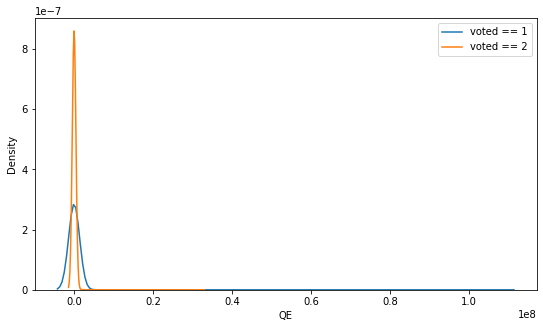

In [28]:
kdeplots('QE')

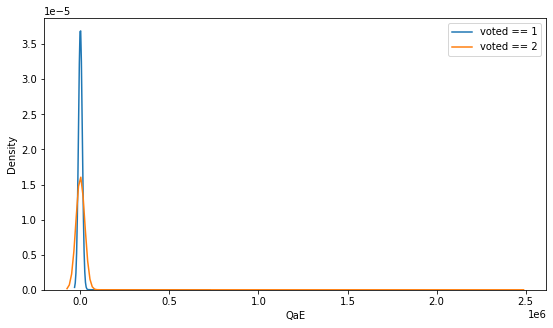

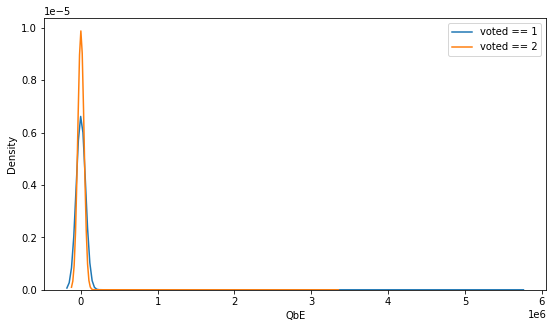

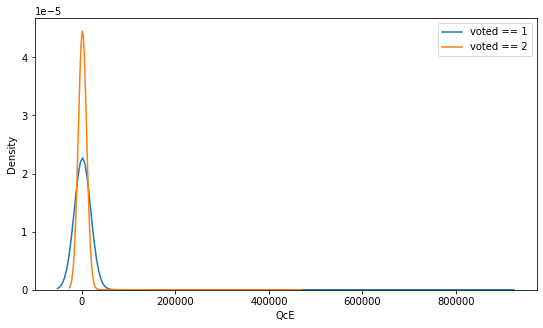

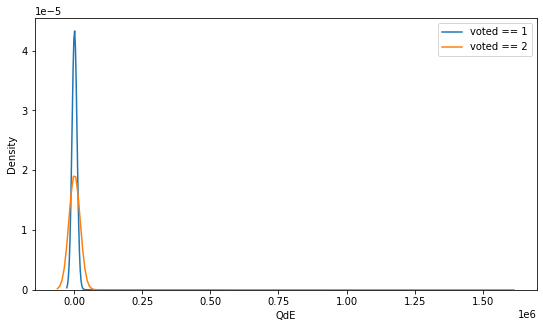

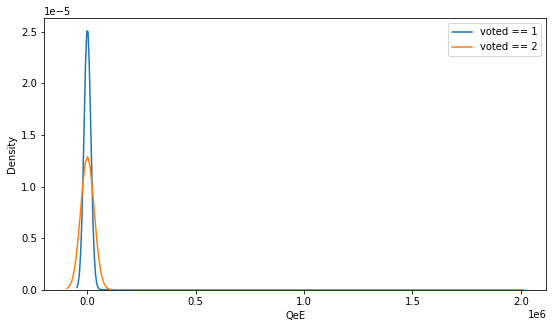

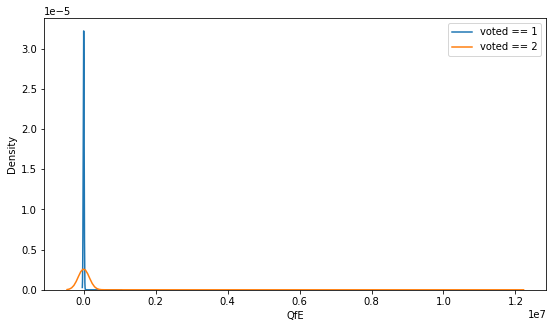

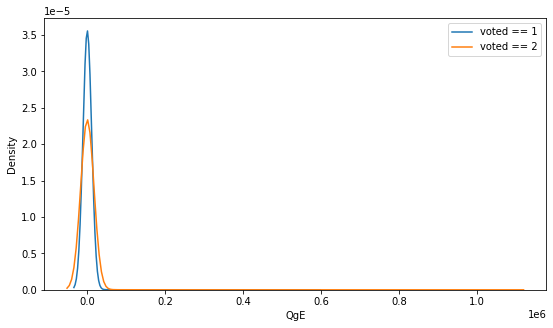

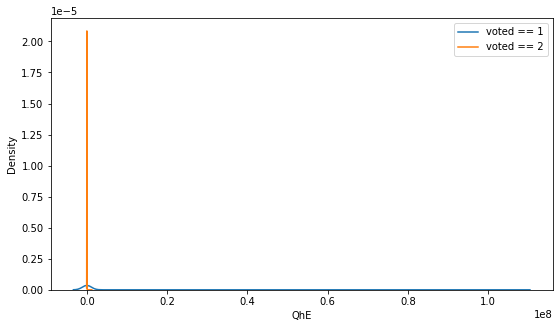

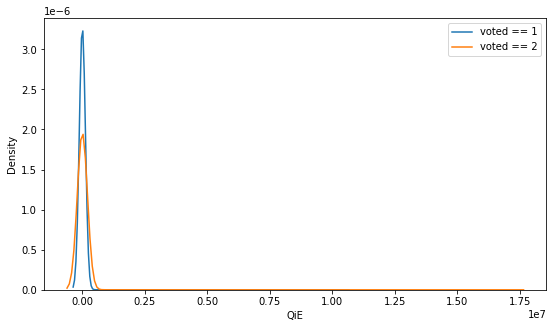

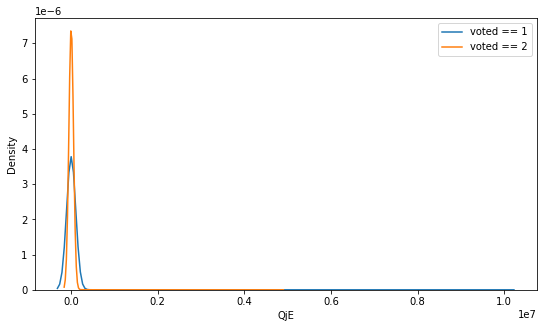

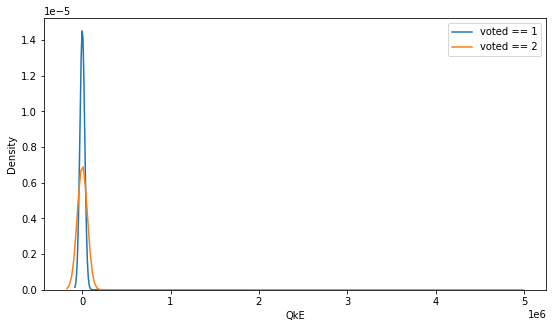

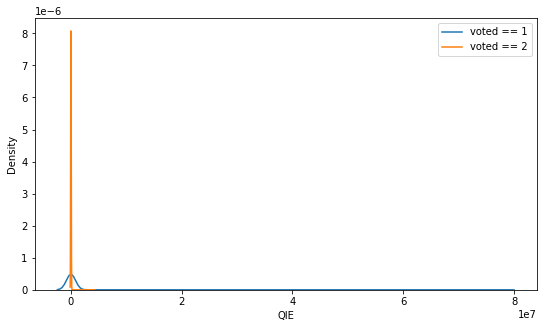

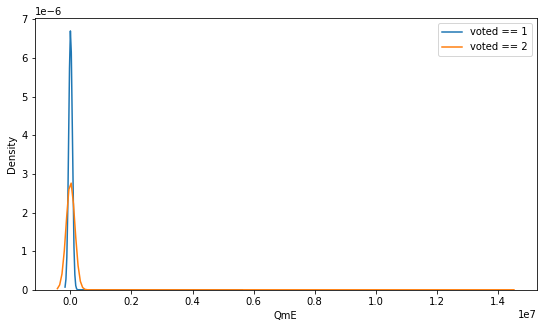

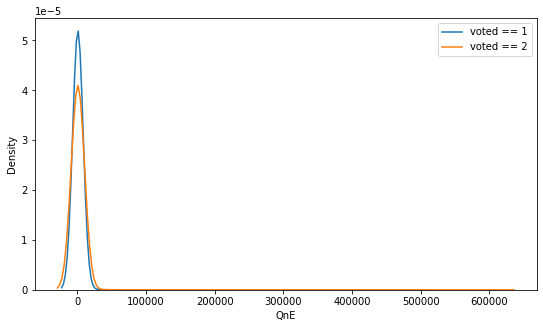

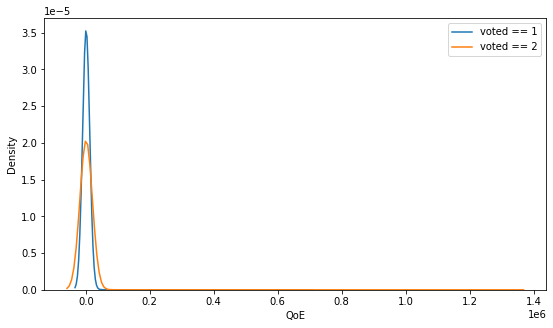

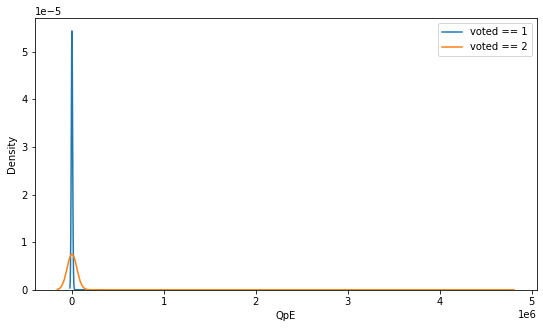

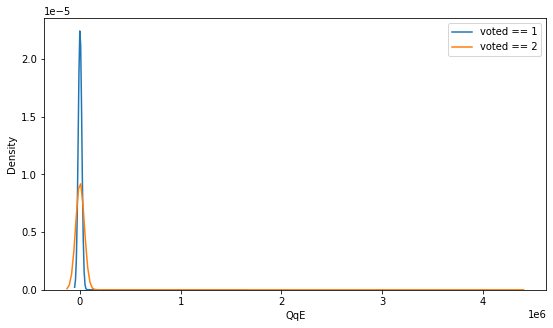

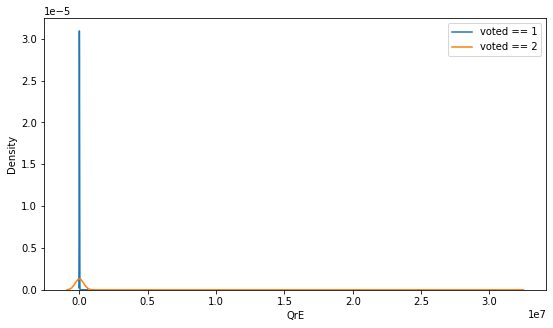

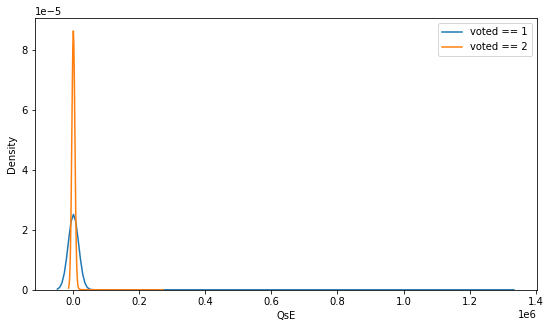

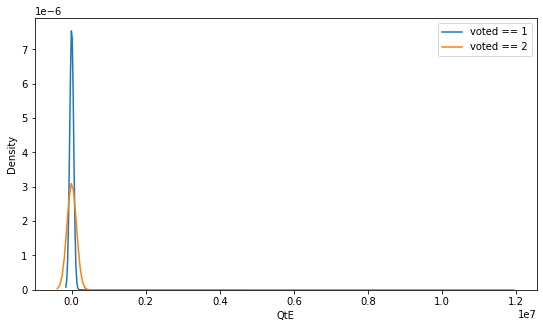

In [29]:
for f in Q_E:
    kdeplots(f)

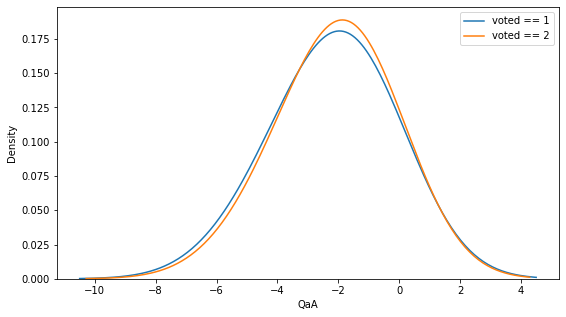

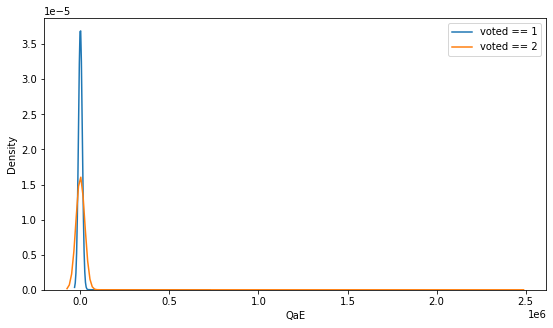

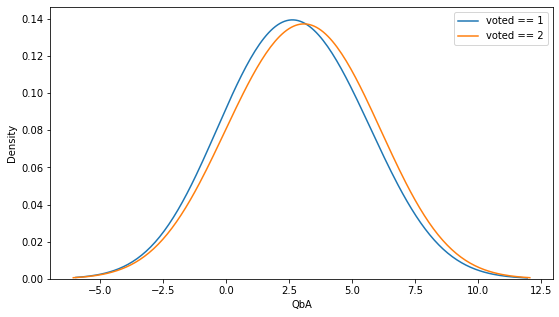

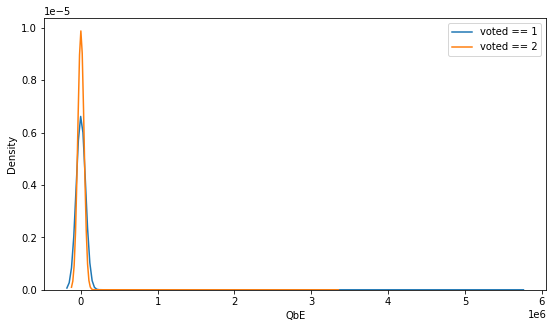

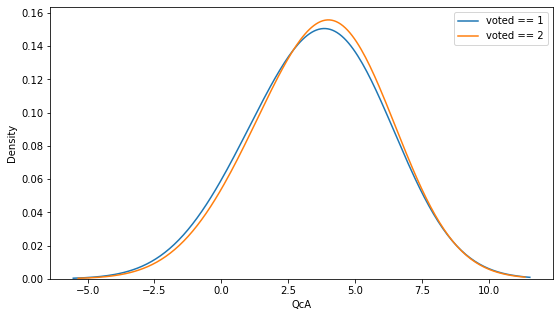

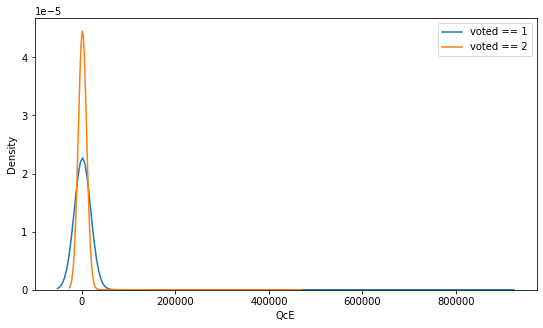

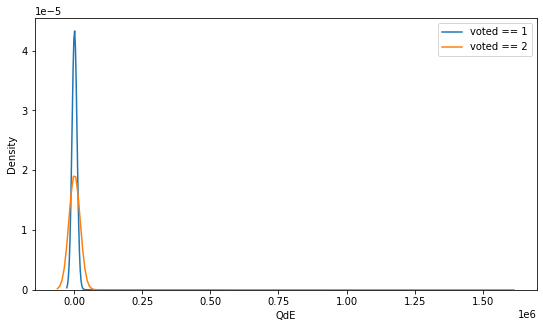

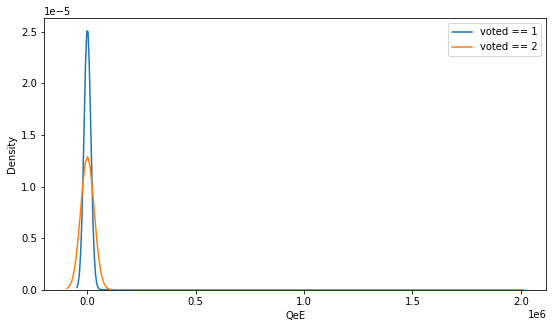

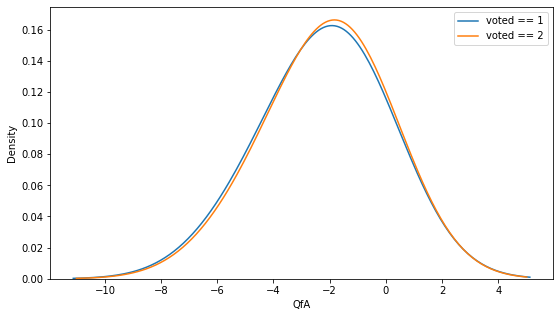

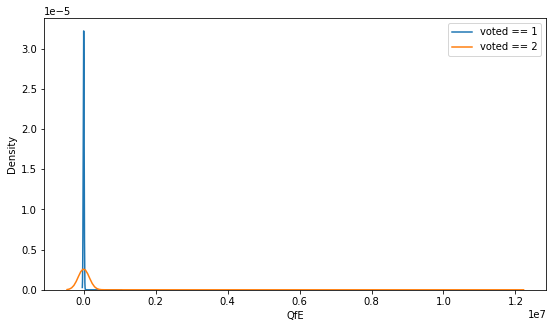

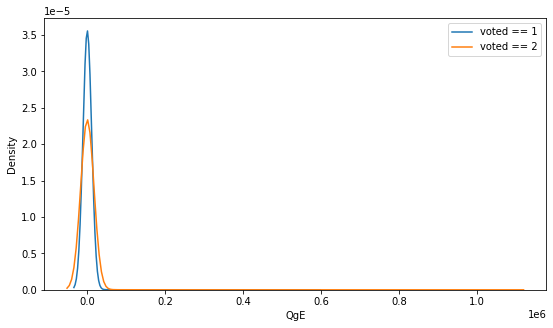

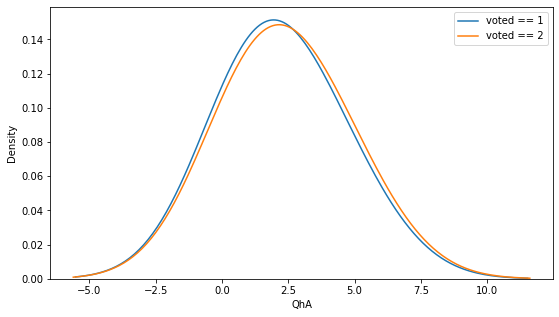

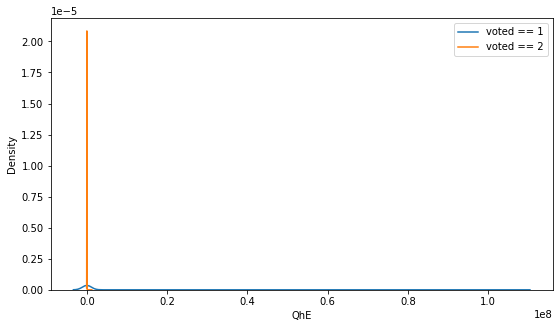

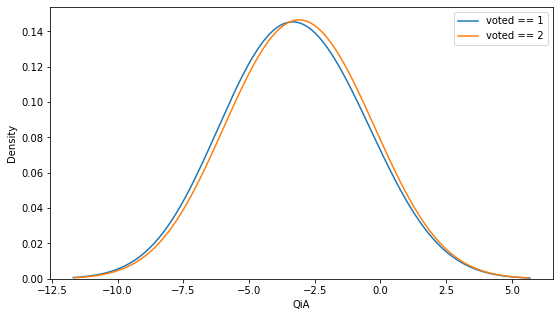

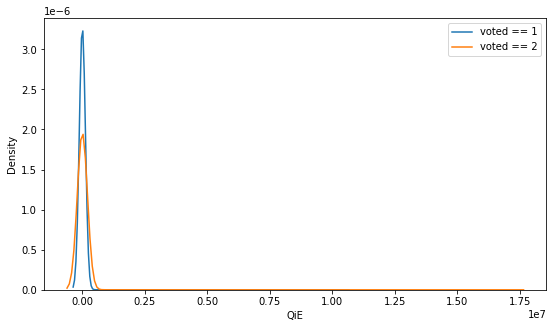

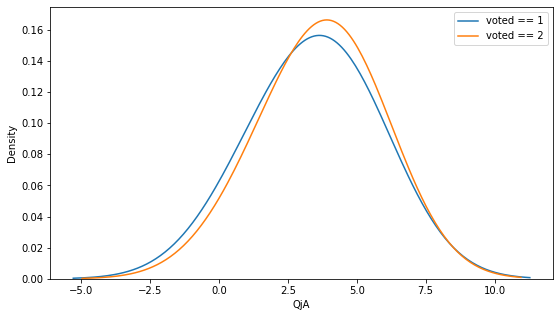

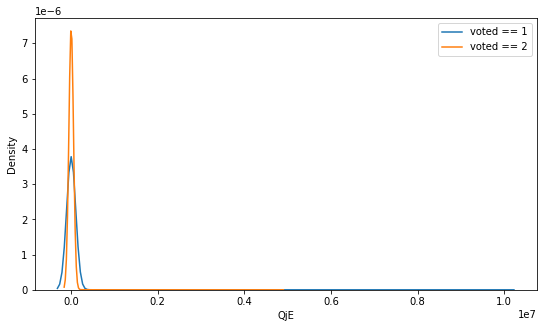

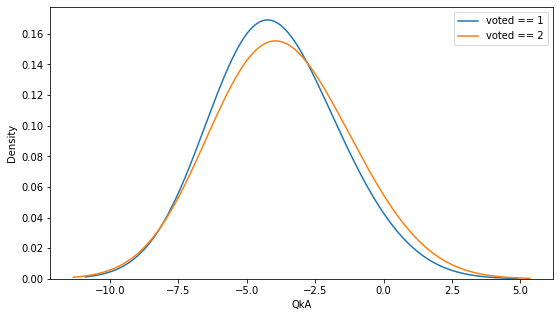

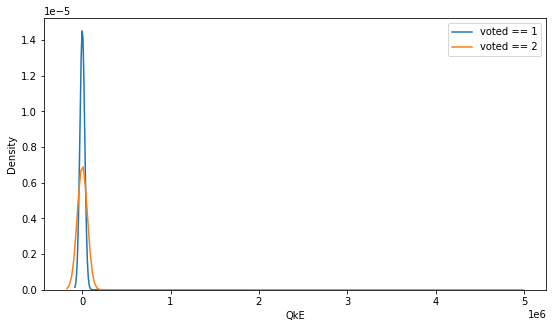

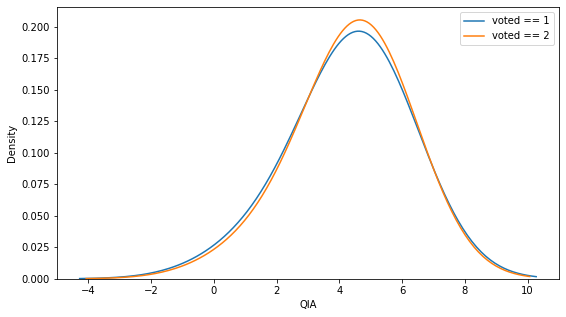

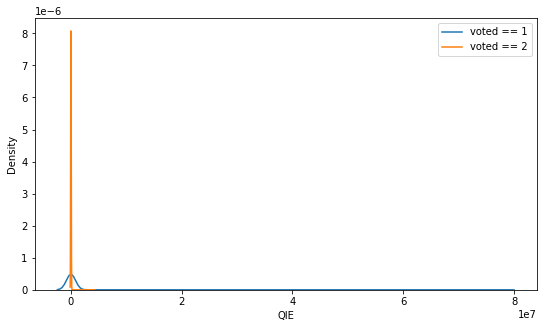

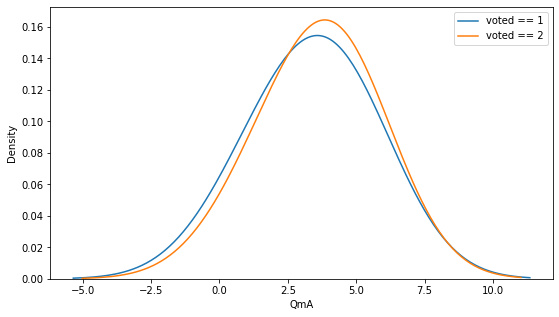

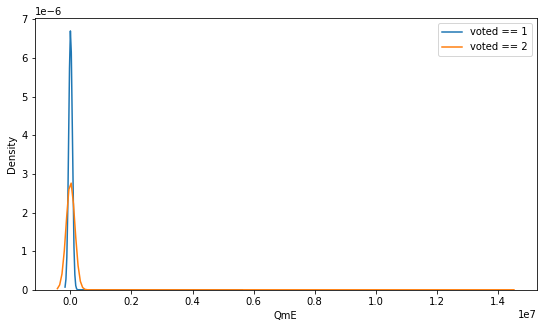

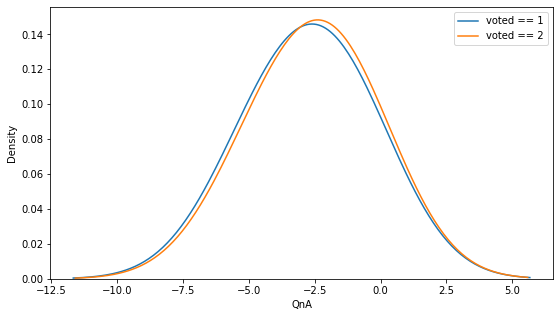

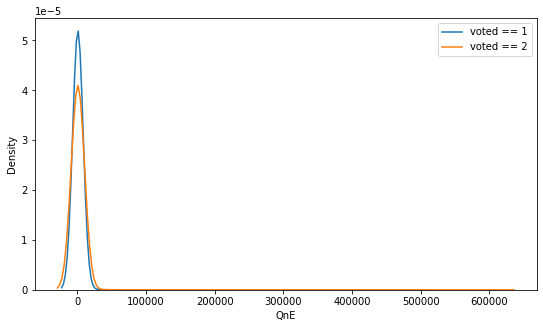

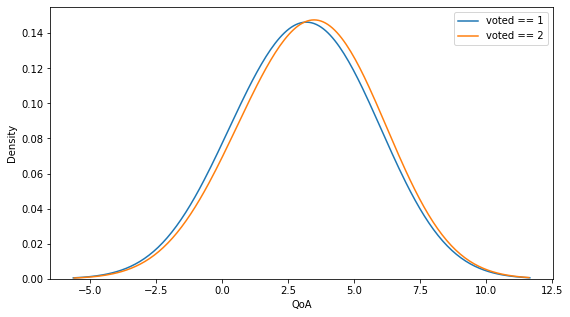

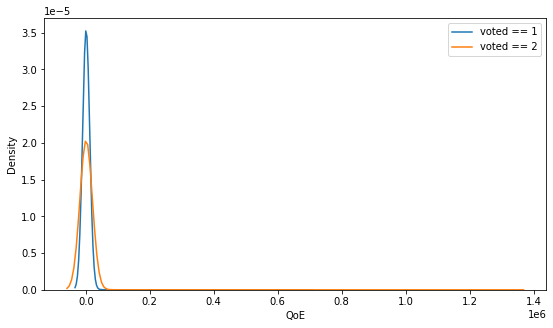

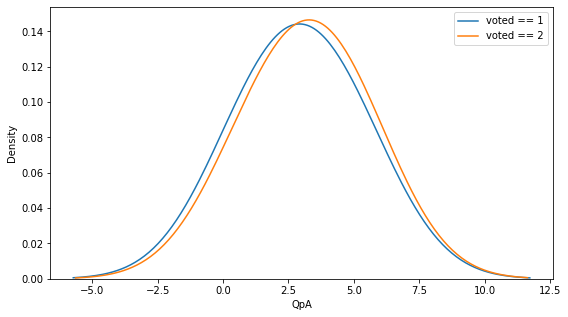

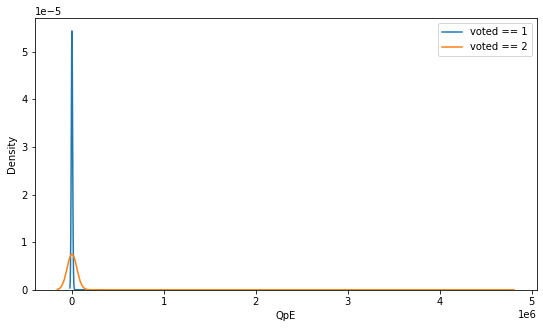

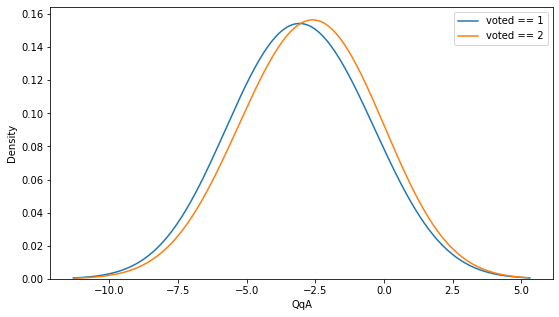

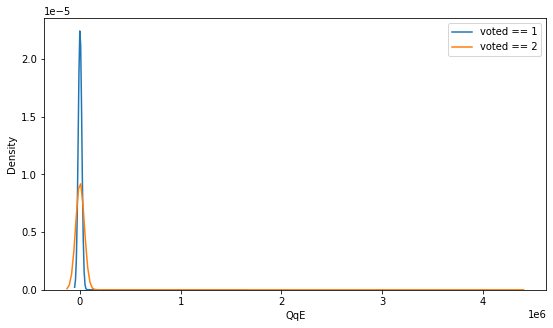

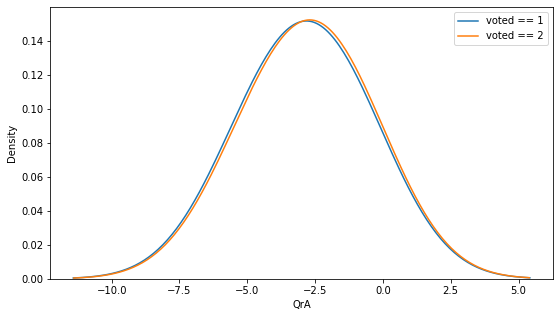

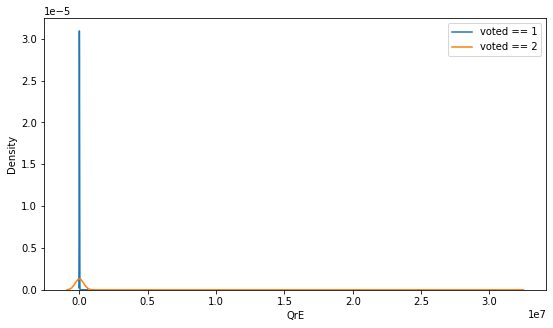

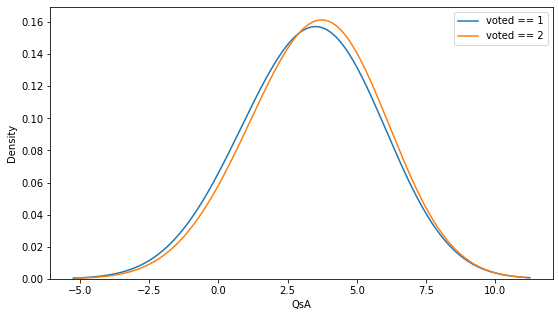

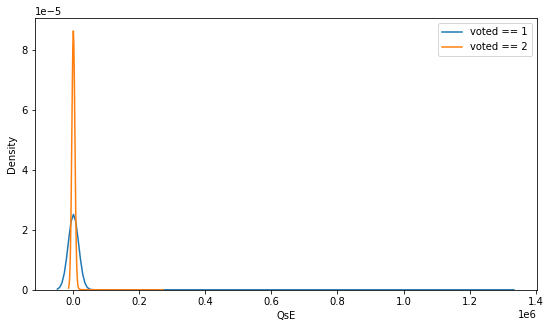

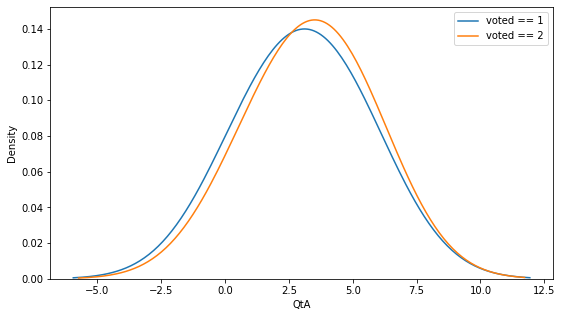

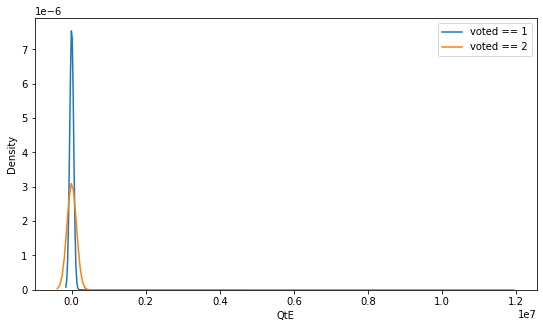

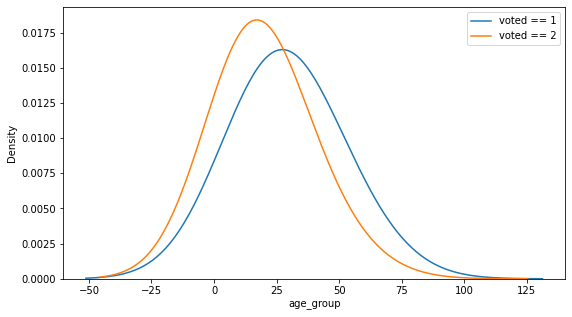

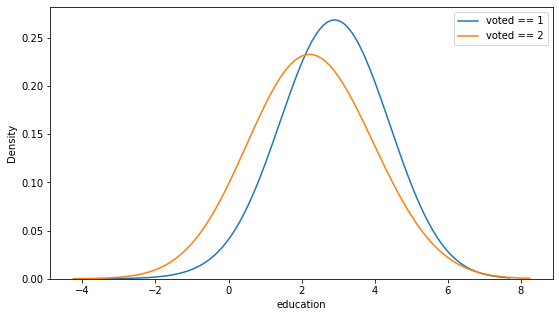

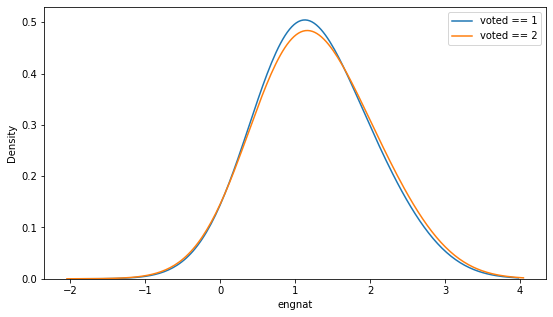

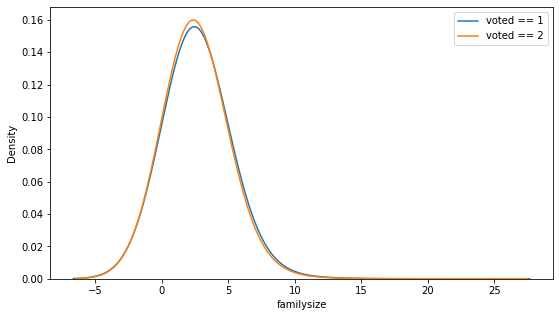

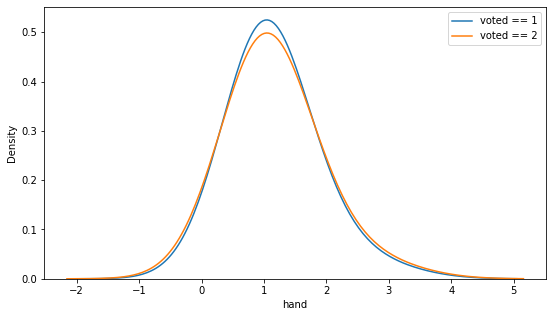

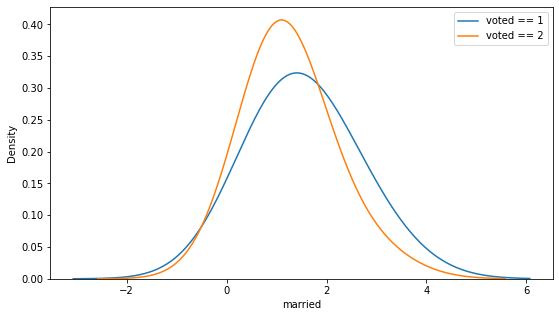

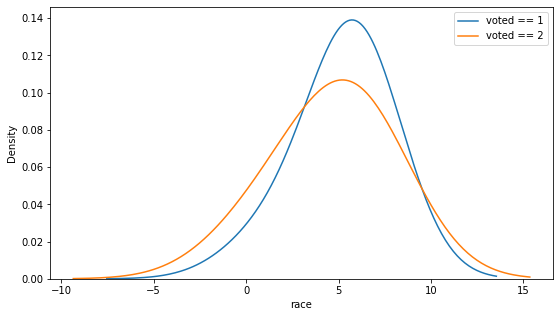

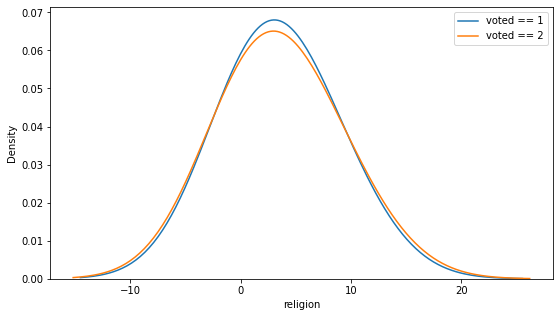

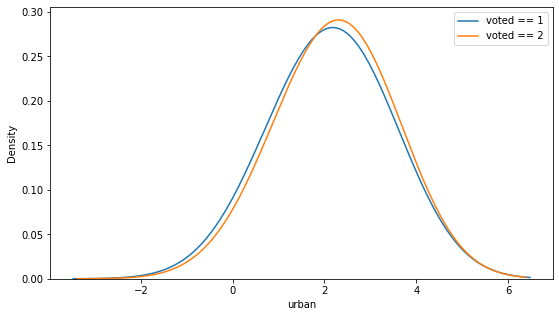

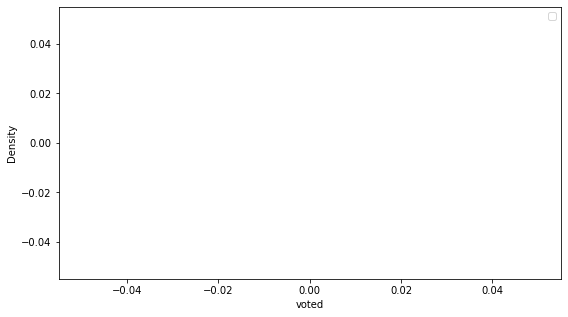

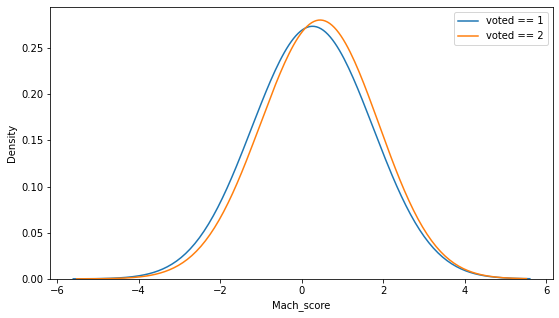

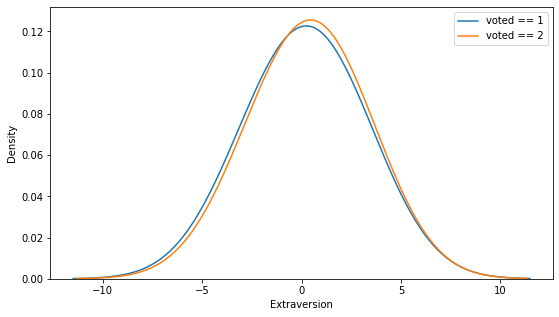

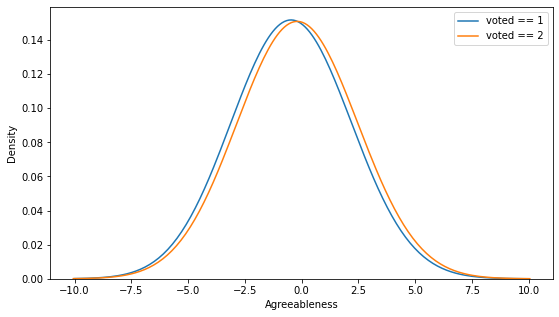

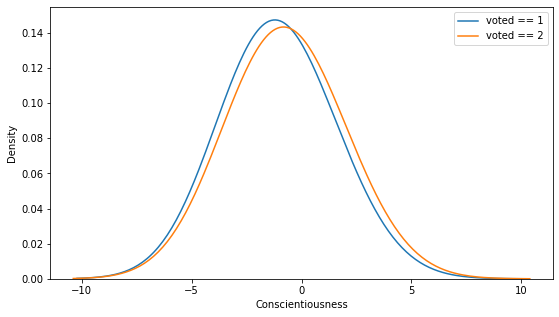

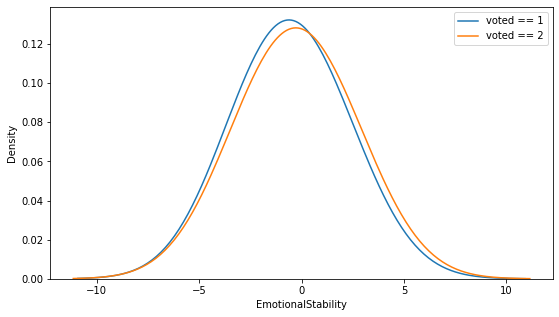

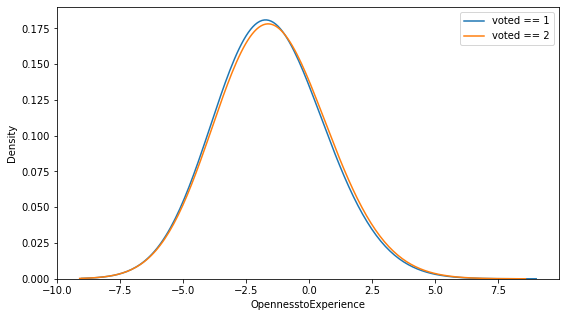

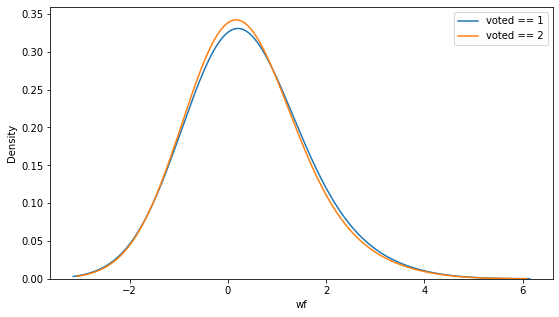

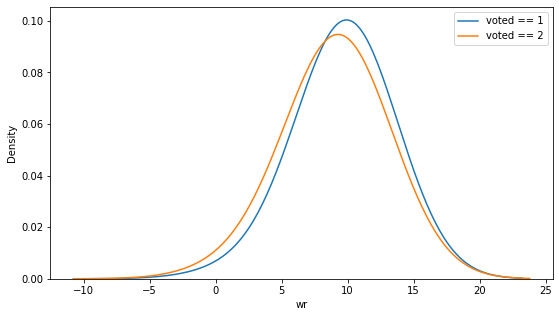

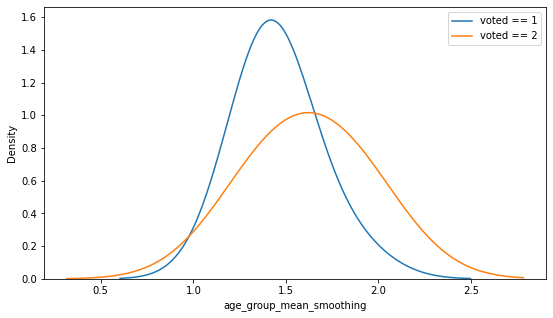

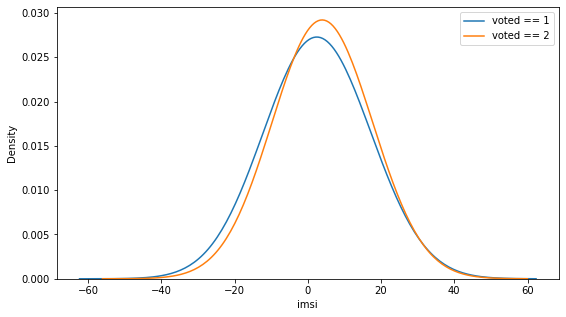

In [32]:
for f in ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdE', 'QeE',
       'QfA', 'QfE', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'hand',
       'married', 'race', 'religion', 'urban', 'voted',
       'Mach_score', 'Extraversion', 'Agreeableness', 'Conscientiousness',
       'EmotionalStability', 'OpennesstoExperience', 'wf', 'wr',
       'age_group_mean_smoothing', 'imsi']:
    kdeplots(f)

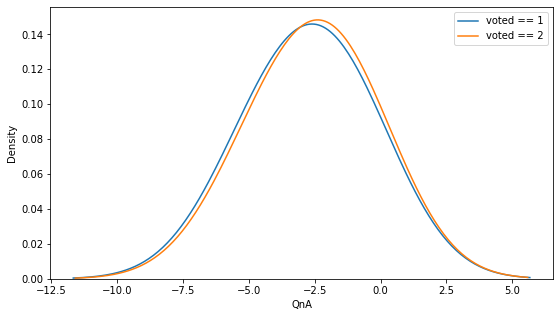

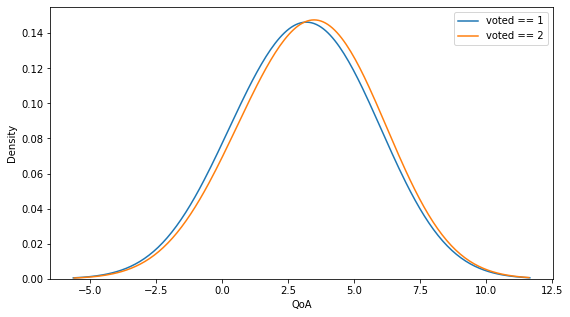

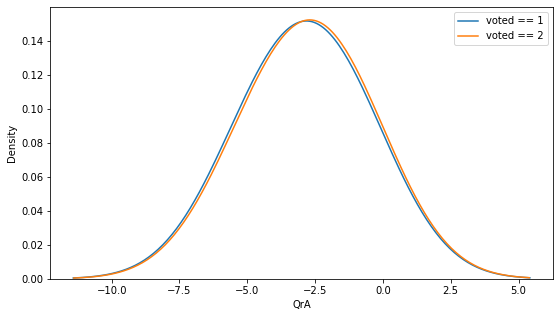

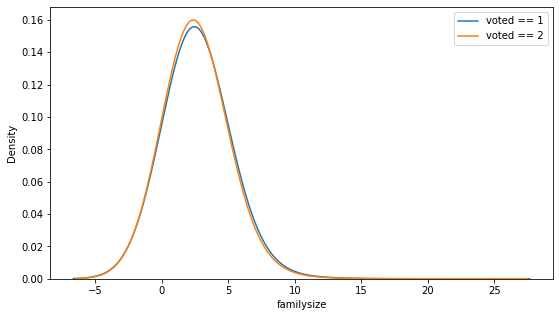

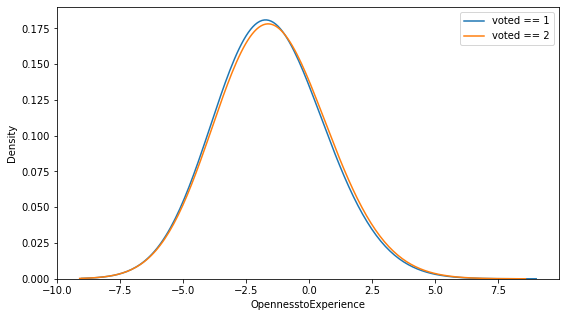

In [34]:
for f in ['QnA', 'QoA', 'QrA', 'familysize', 'OpennesstoExperience']:
    kdeplots(f)